In [ ]:

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from lightgbm import LGBMRegressor
import optuna
from sklearn.base import clone
import pandas as pd
import numpy as np
import joblib
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve, KFold  #
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
# Import required libraries
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..'))
from src.data.data_loader import load_raw_data
from src.features.feature_engineering import FeatureEngineering, FlagClusteringTransformer,PreprocessingFeaturesTransformer, PreprocessingFeatures
from category_encoders import TargetEncoder


In [2]:
raw_data = load_raw_data('../../data/raw/raw_data.csv')

2025-08-12 13:31:36,975 - src.data.data_loader - INFO - Successfully loaded 48665 rows from ../../data/raw/raw_data.csv


In [ ]:
feat_to_drop = [
    "cd_type_individual",
    "cd_advertise",
    "cd_client",
    "flg_rain_sensor",
    "flg_diesel",
    "flg_eletrico",
    "flg_benzina",
    "flg_pcd",
    "flg_trade_in",
    "flg_armored",
    "flg_factory_warranty",
    "flg_all_dealership_schedule_vehicle",
    "flg_all_dealership_services",
    "flg_single_owner",
    "priority",
    "cd_model_vehicle",
    "cd_version_vehicle",
    "flg_lincese",
    "flg_tax_paid",
    "n_doors",
    "flg_alloy_wheels",
    "flg_gas_natural",
]

pipeline_pre = Pipeline(
    [
        (
            "preprocessing",
            PreprocessingFeaturesTransformer(
                location_col="city_state",
                fuel_type_column="fuel_type",
                cols_to_drop=feat_to_drop,
                outlier_columns=["vl_advertise", "km_vehicle"],
            ),
        ),
        (
            "feat_engineering",
            FlagClusteringTransformer(
                feature_flag_cols=[
                    "flg_gasolina",
                    "flg_electric_locks",
                    "flg_air_conditioning",
                    "flg_electric_windows",
                    "flg_rear_defogger",
                    "flg_heater",
                    "flg_alarm",
                    "flg_airbag",
                    "flg_abs",
                ]
            ),
        ),
    ]
)

In [69]:
df_processed = pipeline_pre.fit_transform(
            raw_data)

2025-08-12 17:47:37,983 - src.features.feature_engineering - INFO - 📈 Numerical features: 5
2025-08-12 17:47:37,987 - src.features.feature_engineering - INFO - 🏷️ Categorical features: 35
2025-08-12 17:47:37,988 - src.features.feature_engineering - INFO - 🎯 Target variable: ['flg_leads', 'leads']
2025-08-12 17:47:37,988 - src.features.feature_engineering - INFO - Runnig location split...
2025-08-12 17:47:39,616 - src.features.feature_engineering - INFO - Converting flag columns to integer type...
2025-08-12 17:47:39,882 - src.features.feature_engineering - INFO - Flag columns converted to integer type successfully
2025-08-12 17:47:39,883 - src.features.feature_engineering - INFO - Converting fuel type to flag columns...
2025-08-12 17:47:39,890 - src.features.feature_engineering - INFO - Found 7 unique fuel types: ['alcool', 'gasolina', 'gas', 'natural', 'diesel', 'eletrico', 'benzina']
2025-08-12 17:47:40,027 - src.features.feature_engineering - INFO - Removing duplicate columns...
202

In [70]:
df_processed.columns

Index(['leads', 'cd_vehicle_brand', 'year_model', 'zip_2dig', 'vl_advertise',
       'n_photos', 'km_vehicle', 'vl_market', 'transmission_type',
       'flg_leather_seats', 'flg_parking_sensor', 'city', 'state',
       'flg_alcool', 'flag_cluster'],
      dtype='object')

In [ ]:


# Fit the pipeline
X = df_processed.drop('leads', axis=1)  # Features
y = df_processed['leads']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the column names to ensure all required columns exist
print("Columns in X_train:", X_train.columns)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('encoding', ColumnTransformer(
        transformers=[
            ('city', TargetEncoder(cols=['city'], smoothing=0.5, min_samples_leaf=1000), ['city']),
            ('state', TargetEncoder(cols=['state'], smoothing=5, min_samples_leaf=500), ['state']),
            ('scaler', StandardScaler(), ['views', 'phone_clicks', 'vl_advertise', 'km_vehicle', 'vl_market']),
            ('transmission', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['transmission_type'])
        ],
        remainder='passthrough'  # Keep the other columns unchanged
    )),
    ('model', LGBMRegressor(learning_rate=0.01, reg_alpha=1, num_leaves=20, max_depth=10, n_estimators=300,))  # LightGBM Regressor
])

# Set up K-fold cross-validation with stratification on the training data
kf = KFold(n_splits=5, shuffle=True, random_state=42)

Columns in X_train: Index(['cd_vehicle_brand', 'year_model', 'zip_2dig', 'vl_advertise',
       'n_photos', 'km_vehicle', 'vl_market', 'transmission_type',
       'flg_leather_seats', 'flg_parking_sensor', 'city', 'state',
       'flg_alcool', 'flag_cluster'],
      dtype='object')


In [ ]:


prep = clone(pipeline.named_steps["encoding"])

prep.fit(X_train, y_train)
X_tr = prep.transform(X_train)
X_te = prep.transform(X_test)


def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 2, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.3, 1.0),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 150,150)
    }
    model = LGBMRegressor(**param)
    model.fit(X_tr, y_train, eval_set=[(X_te, y_test)])
    preds = model.predict(X_te)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    return rmse
study = optuna.create_study(direction='minimize')
optuna.logging.disable_default_handler()
study.optimize(objective, n_trials=150)


Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[411]	valid_0's l2: 128.841
Training until validation scores don't improve for 150 rounds
Did not meet early stopping. Best iteration is:
[372]	valid_0's l2: 129.487
Training until validation scores don't improve for 150 rounds
Did not meet early stopping. Best iteration is:
[556]	valid_0's l2: 129.365
Training until validation scores don't improve for 150 rounds
Did not meet early stopping. Best iteration is:
[701]	valid_0's l2: 131.816
Training until validation scores don't improve for 150 rounds
Early stopping, best iteration is:
[266]	valid_0's l2: 132.899
Training until validation scores don't improve for 150 rounds
Did not meet early stopping. Best iteration is:
[658]	valid_0's l2: 131.056
Training until validation scores don't improve for 150 rounds
Did not meet early stopping. Best iteration is:
[599]	valid_0's l2: 132.93
Training until validation scores don't improve for 150 rounds

In [65]:
best_params = study.best_params
best_params["verbosity"] = -1
best_params.pop('early_stopping_rounds', None) 
print(best_params) # Remove early_stopping_rounds if it exists

{'n_estimators': 979, 'learning_rate': 0.0397585702336511, 'num_leaves': 93, 'max_depth': 5, 'min_data_in_leaf': 14, 'feature_fraction': 0.6330668812240319, 'verbosity': -1}


In [66]:
baseline_pred = np.full_like(y_train, y_train.mean(), dtype=float)
baseline_mse = np.mean((y_train - baseline_pred) ** 2)

print("MSE baseline:", baseline_mse)

MSE baseline: 135.5174330920903


## Avaliação de Curva de Aprendizado e Overfitting

Vamos plotar a curva de aprendizado (learning curve) para avaliar se há overfitting/underfitting e também reforçar a análise com o scatter plot de valores reais vs preditos.

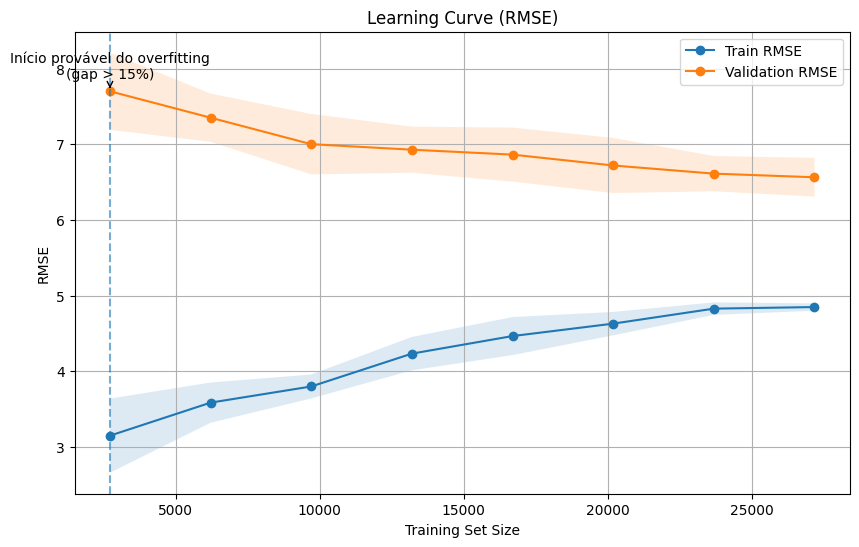

⚠️ Possível overfitting (último ponto): gap=1.715, gap/train=35.4% (> 15%)
Teste: RMSE=6.922 | MSE=47.912 | R²=0.703


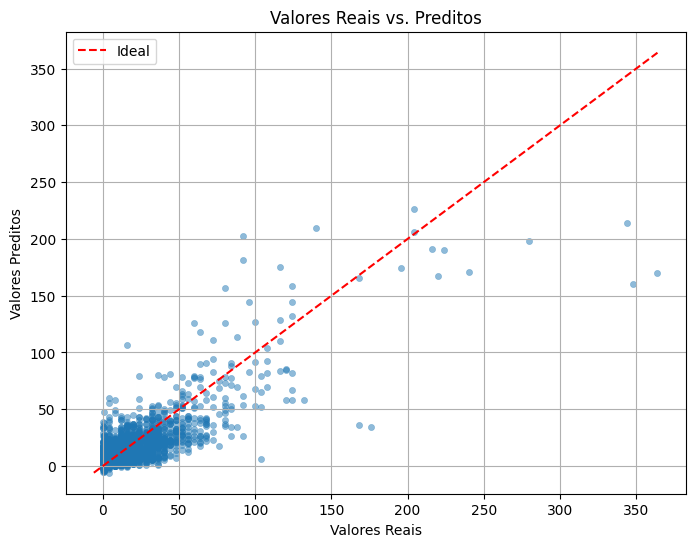

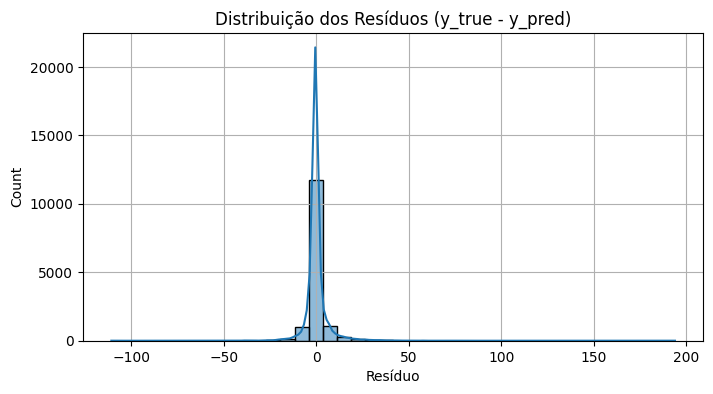

In [67]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ===== 1) Curva de aprendizado (RMSE) =====
cv = KFold(n_splits=5, shuffle=True, random_state=42)

pipeline.named_steps['model'].set_params(**best_params)

train_sizes, train_scores, test_scores = learning_curve(
    estimator=pipeline,
    X=X_train, y=y_train,
    cv=cv,
    scoring='neg_root_mean_squared_error',  
    train_sizes=np.linspace(0.1, 1.0, 8),
    n_jobs=-1,
    shuffle=True,
    random_state=42,
    return_times=False
)

train_rmse = -train_scores
test_rmse  = -test_scores

train_mean = train_rmse.mean(axis=1)
train_std  = train_rmse.std(axis=1)
test_mean  = test_rmse.mean(axis=1)
test_std   = test_rmse.std(axis=1)

gap = test_mean - train_mean
gap_ratio = gap / np.maximum(train_mean, 1e-9)  

threshold = 0.15
min_consecutive = 2
start_idx = None
streak = 0
for i in range(len(train_sizes)):
    if gap_ratio[i] > threshold:
        streak += 1
        if streak >= min_consecutive:
            start_idx = i - min_consecutive + 1
            break
    else:
        streak = 0

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Train RMSE')
plt.plot(train_sizes, test_mean, 'o-', label='Validation RMSE')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15)
plt.fill_between(train_sizes, test_mean - test_std,   test_mean + test_std,   alpha=0.15)
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.title('Learning Curve (RMSE)')
plt.grid(True)
plt.legend()

if start_idx is not None:
    x0 = train_sizes[start_idx]
    y0 = test_mean[start_idx]
    plt.axvline(x0, linestyle='--', alpha=0.6)
    plt.annotate(
        f'Início provável do overfitting\n(gap > {int(threshold*100)}%)',
        xy=(x0, y0),
        xytext=(x0, y0 + (test_mean.max()-test_mean.min())*0.15),
        arrowprops=dict(arrowstyle='->', lw=1),
        ha='center'
    )
plt.show()

last_gap = gap[-1]
last_ratio = gap_ratio[-1]
if last_ratio > threshold:
    print(f"⚠️ Possível overfitting (último ponto): gap={last_gap:.3f}, gap/train={last_ratio:.1%} (> {threshold:.0%})")
else:
    print(f"✅ Sem sinais claros no último ponto: gap={last_gap:.3f}, gap/train={last_ratio:.1%} (≤ {threshold:.0%})")

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)
print(f"Teste: RMSE={rmse:.3f} | MSE={mse:.3f} | R²={r2:.3f}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, s=20, edgecolor=None)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--', label='Ideal')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Valores Reais vs. Preditos')
plt.legend()
plt.grid(True)
plt.show()

# (Opcional) Resíduos
res = y_test - y_pred
plt.figure(figsize=(8, 4))
sns.histplot(res, bins=40, kde=True)
plt.title('Distribuição dos Resíduos (y_true - y_pred)')
plt.xlabel('Resíduo')
plt.grid(True)
plt.show()
